This code is for EN5423 class at GIST, Republic of Korea, and created by Dr. Hyunglok Kim.  
**Contact information**: hyunglokkim@gist.ac.kr  
**License**: This work is licensed for non-commercial use only.  
**Restrictions**: Do not use this material without permission for teaching or developing other classes.

In [30]:
import numpy as np
from scipy.stats import bartlett
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.utils import resample
from scipy.stats import ranksums
from scipy.stats import t
from scipy.stats import fligner
from scipy.stats import levene

In [4]:
# Example 1-3 Hodges-Lehmann estimator
def wilcoxon_rank_sum_test_with_hl_ci(x, y, alpha=0.05):
    # Perform the Mann-Whitney U test with continuity correction
    stat, p = mannwhitneyu(x, y, alternative='two-sided', use_continuity=True)

    # Calculate all pairwise differences
    diff = np.array([i - j for i in x for j in y])
    sorted_diff = np.sort(diff)

    # Compute the Hodges-Lehmann estimator for the median of the differences
    hl_estimate = np.median(sorted_diff)

    # The total number of pairwise differences
    N = len(diff)
    n = len(x)
    m = len(y)
    
    # Get the critical z value for the alpha level
    z_alpha = norm.ppf(1 - alpha / 2)

    # Calculate the ranks for the confidence intervals
    Rl = (N - z_alpha * np.sqrt(N * (n + m + 1) / 3)) / 2
    Ru = N - Rl + 1

    # Make sure ranks are within the range of the number of differences
    Rl = max(1, min(N, int(np.floor(Rl))))
    Ru = max(1, min(N, int(np.ceil(Ru))))

    # Extract confidence intervals from the sorted differences
    ci_lower = sorted_diff[Rl - 1]
    ci_upper = sorted_diff[Ru - 1]

    return {
        'W-statistic': stat,
        'p-value': p,
        'Hodges-Lehmann estimate': hl_estimate,
        '95% confidence interval': (ci_lower, ci_upper)
    }

# Data from the question
X = np.array([0.59, 0.87, 1.10, 1.10, 1.20, 1.30, 1.60, 1.70, 3.20, 4.00])
Y = np.array([0.30, 0.36, 0.50, 0.70, 0.70, 0.90, 0.92, 1.00, 1.30, 9.70])

# Perform the test and output the results
results = wilcoxon_rank_sum_test_with_hl_ci(X, Y)
print(f"W-statistic: {results['W-statistic']:.2f}")
print(f"P-value: {results['p-value']:.5f}")
print(f"Hodges-Lehmann Estimate: {results['Hodges-Lehmann estimate']:.6f}")
print(f"95% Confidence Interval: ({results['95% confidence interval'][0]:.6f}, {results['95% confidence interval'][1]:.6f})")


W-statistic: 76.50
P-value: 0.04911
Hodges-Lehmann Estimate: 0.505000
95% Confidence Interval: (0.000000, 1.100000)


In [5]:
X = np.array([15, 17, 25])
Y = np.array([8,27,3,5])

wilcoxon_rank_sum_test_with_hl_ci(X, Y, alpha=0.05)

{'W-statistic': 9.0,
 'p-value': 0.4,
 'Hodges-Lehmann estimate': 11.0,
 '95% confidence interval': (-12, 22)}

In [17]:
import numpy as np
from scipy.stats import t

def welch_df(n1, s1, n2, s2):
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1**2 / (n1**2 * (n1 - 1))) + (s2**2 / (n2**2 * (n2 - 1)))
    df = numerator / denominator
    return df

def welch_t_conf_interval(x_bar, s1, n1, y_bar, s2, n2, alpha=0.05):
    df = welch_df(n1, s1, n2, s2)
    t_crit = t.ppf(1 - alpha/2, df)
    se = np.sqrt(s1/n1 + s2/n2)
    margin_of_error = t_crit * se
    diff_means = x_bar - y_bar
    
    lower_bound = diff_means - margin_of_error
    upper_bound = diff_means + margin_of_error
    
    return (lower_bound, upper_bound)

# Data for X and Y
X = np.array([0.59, 0.87, 1.10, 1.10, 1.20, 1.30, 1.60, 1.70, 3.20, 4.00])
Y = np.array([0.30, 0.36, 0.50, 0.70, 0.70, 0.90, 0.92, 1.00, 1.30, 9.70])

# Calculating statistics for X
x_bar = np.mean(X)
s1 = np.var(X, ddof=1)  # Using sample variance (ddof=1)
n1 = len(X)

# Calculating statistics for Y
y_bar = np.mean(Y)
s2 = np.var(Y, ddof=1)  # Using sample variance (ddof=1)
n2 = len(Y)

# Calculating the 95% confidence interval
alpha = 0.05  # 95% confidence level
ci = welch_t_conf_interval(x_bar, s1, n1, y_bar, s2, n2, alpha)
ci


(-2.0814786271765224, 2.1374786271765225)

In [18]:
def bootstrap_confidence_interval(data1, data2, num_iterations=10000, alpha=0.05):
    """Calculate bootstrap confidence interval for the difference in means."""
    np.random.seed(42)  # For reproducibility
    n1 = len(data1)
    n2 = len(data2)
    mean_diffs = []
    
    for _ in range(num_iterations):
        sample1 = np.random.choice(data1, n1, replace=True)
        sample2 = np.random.choice(data2, n2, replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        mean_diffs.append(mean_diff)
        
    lower_bound = np.percentile(mean_diffs, (alpha/2)*100)
    upper_bound = np.percentile(mean_diffs, (1-alpha/2)*100)
    
    return np.mean(data1), np.mean(data2), np.mean(mean_diffs), lower_bound, upper_bound

# Assuming data follows a normal distribution around the provided means
np.random.seed(42)
indust = np.random.normal(1.666, 0.1, 300)  # Normal distribution around mean 1.666
residen = np.random.normal(1.638, 0.1, 300)  # Normal distribution around mean 1.638

# Compute the bootstrap confidence interval
mean_indust, mean_residen, mean_diff, ci_lower, ci_upper = bootstrap_confidence_interval(indust, residen)

print(f"Mean of indust: {mean_indust:.3f}")
print(f"Mean of residen: {mean_residen:.3f}")
print(f"Diff of means: {mean_diff:.3f}")
print(f"95 percent confidence interval: ({ci_lower:.3f}, {ci_upper:.3f})")


Mean of indust: 1.665
Mean of residen: 1.636
Diff of means: 0.030
95 percent confidence interval: (0.014, 0.045)


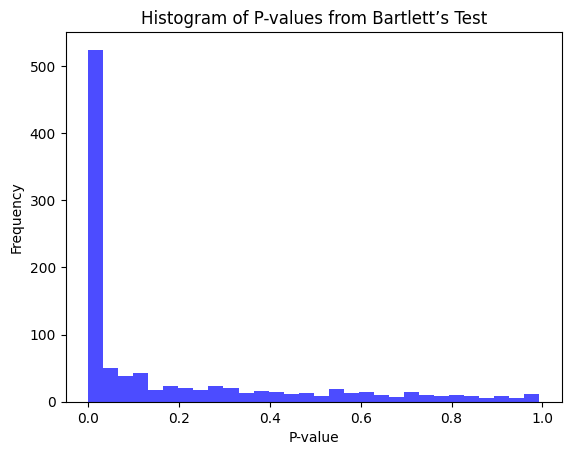

Number of significant tests (out of 1000): 554


In [25]:
# Example 4 Simulating Bartlett's Test on Lognormal Data
def simulate_bartlett_test(mean_log, sd_log, num_samples, num_repetitions):
    """Simulate Bartlett's test on lognormal data across multiple repetitions.

    Args:
        mean_log (float): Mean of the logarithm of the distribution.
        sd_log (float): Standard deviation of the logarithm of the distribution.
        num_samples (int): Number of observations in each simulated group.
        num_repetitions (int): Number of repetitions for the simulation.

    Returns:
        list: p-values from each repetition's Bartlett's test.
    """
    p_values = []
    
    for _ in range(num_repetitions):
        # Generate two groups of lognormal data
        data1 = np.random.lognormal(mean_log, sd_log, num_samples)
        data2 = np.random.lognormal(mean_log, sd_log, num_samples)
        
        # Perform Bartlett's test on the two groups
        _, p_value = bartlett(data1, data2)
        p_values.append(p_value)
    
    return p_values

# Parameters
mean_log = 0.7
sd_log = 1
num_samples = 50
num_repetitions = 1000

# Run simulation
p_values = simulate_bartlett_test(mean_log, sd_log, num_samples, num_repetitions)

# Plotting the histogram of p-values
plt.hist(p_values, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of P-values from Bartlett’s Test')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

# Assess how many p-values are below 0.05 (significance level)
significant_tests = sum(p < 0.05 for p in p_values)
print(f"Number of significant tests (out of {num_repetitions}): {significant_tests}")

In [29]:
# Example 5 Fligner-Killeen Test for Equal Variance (Nonparametric)
# Parameters for the lognormal distribution
mean_log = 0.7
sd_log = 1

# Generate two groups from the same lognormal distribution
group1 = np.random.lognormal(mean_log, sd_log, 2000)
group2 = np.random.lognormal(mean_log, sd_log, 2000)

# Combine the groups for testing
data = np.concatenate((group1, group2))
groups = ['group1']*2000 + ['group2']*2000

# Conduct the Fligner-Killeen test of homogeneity of variances
stat, p_value = fligner(group1, group2)

print("Fligner-Killeen test of homogeneity of variances")
print(f"data: data and groups")
print(f"Fligner-Killeen: med chi-squared = {stat:.5f}, p-value = {p_value:.4f}")

Fligner-Killeen test of homogeneity of variances
data: data and groups
Fligner-Killeen: med chi-squared = 0.17314, p-value = 0.6773


In [31]:
# Eample 6 Levene’s Test for Equal Variance (Parametric)
val_expl = np.random.lognormal(mean=0.7, sigma=1, size=100)  # Example data generation
group = np.array([1]*50 + [2]*50)  # Example grouping

# Performing Levene's Test for Homogeneity of Variances using median as the center
stat, p_value = levene(val_expl[group == 1], val_expl[group == 2], center='median')

# Printing the results
print("Levene’s Test for Homogeneity of Variance (center = median)")
print(f"Group degrees of freedom: 1, F value: {stat:.4f}, p-value: {p_value:.4f}")

Levene’s Test for Homogeneity of Variance (center = median)
Group degrees of freedom: 1, F value: 0.4547, p-value: 0.5017
